In [64]:
import os
import re
import glob
import librosa
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import kagglehub
import glob

In [65]:
# Downloading dataset
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/Andrej/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [66]:
print("music genres in the dataset:", list(os.listdir(f'{path}/Data/genres_original/')))
print("number of music genres:", len(list(os.listdir(f'{path}/Data/genres_original/'))))

music genres in the dataset: ['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
number of music genres: 10


In [67]:
directory = f'{path}/Data/genres_original/'
# Initialize a variable to store the minimum length
min_length = float('inf')
number_files = 0

# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                number_files += 1
                # Load the audio file using librosa
                y, sr = librosa.load(file_path)

                # Update the minimum length if needed
                min_length = min(min_length, len(y))

print(f"The minimum length of the music time series across all files is: {min_length}, it's corresponds to a minimum of {min_length/22050} seconds")
print("Number of files:", number_files)

The minimum length of the music time series across all files is: 660000, it's corresponds to a minimum of 29.931972789115648 seconds
Number of files: 999


In [68]:
# Defining the directory path
directory = f'{path}/Data/genres_original/'
len_dataset = 0
dataset_filenames = []

# Iterating over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                for i in range(min_length//1024):
                    dataset_filenames.append([file_path, i])
print(len(dataset_filenames))

643356


In [69]:
def extract_string(input_str):
    # Regular expression to capture the string between the first two slashes
    match = re.search(r'/([^/]+)/', input_str)
    if match:
        return match.group(1)
    else:
        return None

### Parameters and Configuration

In [70]:
AUDIO_DIR = f'{path}/Data/genres_original/'    # Directory containing audio files
SAMPLE_RATE = 22050
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 64     # Frequency bins for the Mel-spectrogram
DURATION = 10.0   # Duration of each audio clip in seconds (30s is the entire clip)
GENRES = ['blues','classical','country','disco','hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']  # Example classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# ConvRBM Hyperparameters
VISIBLE_CHANNELS = 1  # Spectrogram is treated as a single "image" channel
HIDDEN_CHANNELS = 16  # Number of convolutional filters
KERNEL_SIZE = (8, 8)
LEARNING_RATE = 1e-3
CD_K = 1    # Contrastive divergence steps
EPOCHS = 1000
BATCH_SIZE = 64


In [71]:
class AudioDataset(Dataset):
    def __init__(self, audio_dir, genres, duration=10.0, n_mels=64):
        self.data = []
        self.labels = []
        self._load_audio_files(audio_dir, genres, duration, n_mels)

    def _load_audio_files(self, audio_dir, genres, duration, n_mels):
        for i, genre in enumerate(genres):
            genre_path = os.path.join(audio_dir, genre)
            for fname in glob.glob(os.path.join(genre_path, "*.wav")):
                audio, sr = librosa.load(
                    fname, 
                    sr=SAMPLE_RATE, 
                    duration=duration)

                # Compute Mel-Spectrogram
                mel_spec = librosa.feature.melspectrogram(
                    y=audio, 
                    sr=SAMPLE_RATE, 
                    n_fft=N_FFT,
                    hop_length=HOP_LENGTH, 
                    n_mels=n_mels)
                # Convert to log scale for better dynamic range
                log_mel = librosa.power_to_db(mel_spec, ref=np.max)
                # Normalize
                log_mel -= log_mel.min()
                log_mel /= log_mel.max()
                
                self.data.append(log_mel)
                self.labels.append(i)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mel_tensor = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel_tensor, label_tensor

In [72]:
def split_dataset(audio_dir=AUDIO_DIR, genres=GENRES, n_mels=N_MELS, test_size=0.1, val_size=0.1, random_seed=14):
    dataset = AudioDataset(audio_dir, genres, n_mels=n_mels)
    
    # Splitting train and test sets
    total_size = len(dataset)
    indices = list(range(total_size))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_seed)
    
    # Further split the training indices into training and validation
    train_indices, val_indices = train_test_split(
        train_indices, test_size=val_size / (1 - test_size), random_state=random_seed)
    
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    return train_subset, val_subset, test_subset

def get_dataloaders(audio_dir, genres=GENRES, n_mels=64, batch_size=BATCH_SIZE, test_size=0.1, val_size=0.1, shuffle=True, random_seed=13):
    train_subset, val_subset, test_subset = split_dataset(
        audio_dir, genres, test_size=test_size, val_size=val_size, n_mels=n_mels, random_seed=random_seed)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [92]:
train_loader_64, val_loader_64, test_loader_64 = get_dataloaders(
    AUDIO_DIR, 
    GENRES, 
    batch_size=BATCH_SIZE, 
    n_mels=N_MELS,
    shuffle=False)

In [93]:
print("Number of training batches:", len(train_loader_64))
print("Number of validation batches:", len(val_loader_64))
print("Number of test batches:", len(test_loader_64))

Number of training batches: 13
Number of validation batches: 2
Number of test batches: 2


### Vizualizing audio recordings

In [94]:
def visualize_spectrogram(loader, sample_index=0):
    """
    Visualize a spectrogram from the given DataLoader.
    Args:
        loader (DataLoader): DataLoader containing the spectrograms.
        sample_index (int): Index of the sample to visualize within the first batch.
    """
    for batch_X, batch_y in loader:
        print("batch_X shape:", batch_X.shape)
        spectrogram = batch_X[sample_index].squeeze(0).cpu().numpy()
        label = GENRES[batch_y[sample_index].item()]
        break

    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Amplitude')
    plt.title(f"Spectrogram for Sample {sample_index} (Label: {label})")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()


batch_X shape: torch.Size([64, 1, 96, 431])


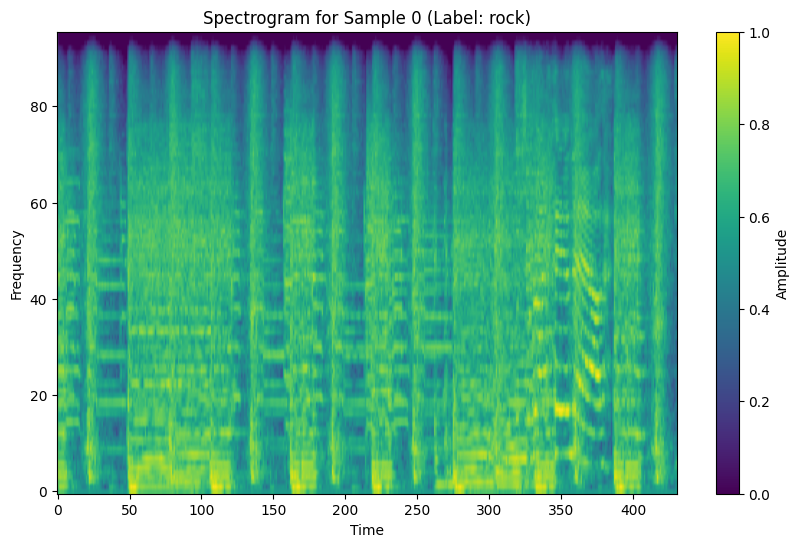

batch_X shape: torch.Size([64, 1, 96, 431])


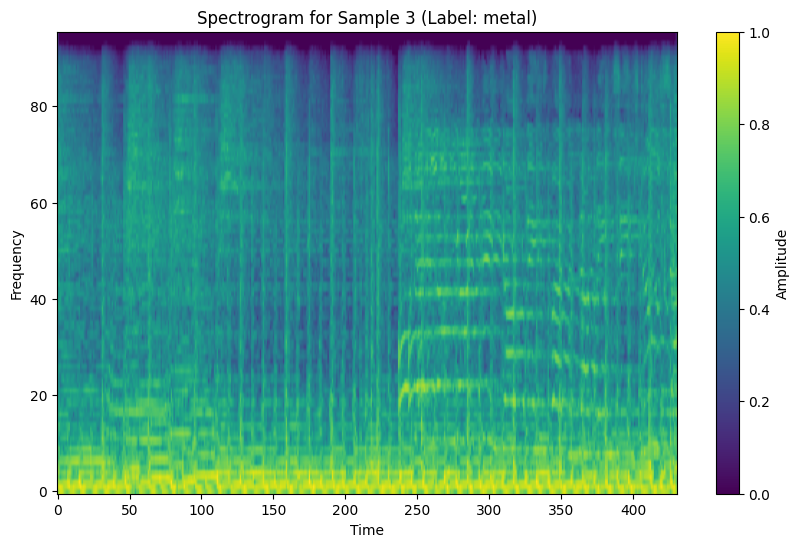

batch_X shape: torch.Size([64, 1, 96, 431])


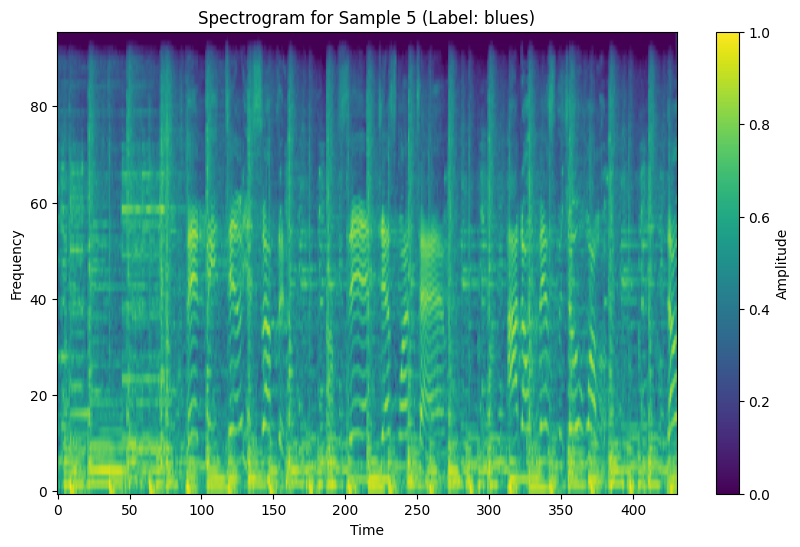

batch_X shape: torch.Size([64, 1, 96, 431])


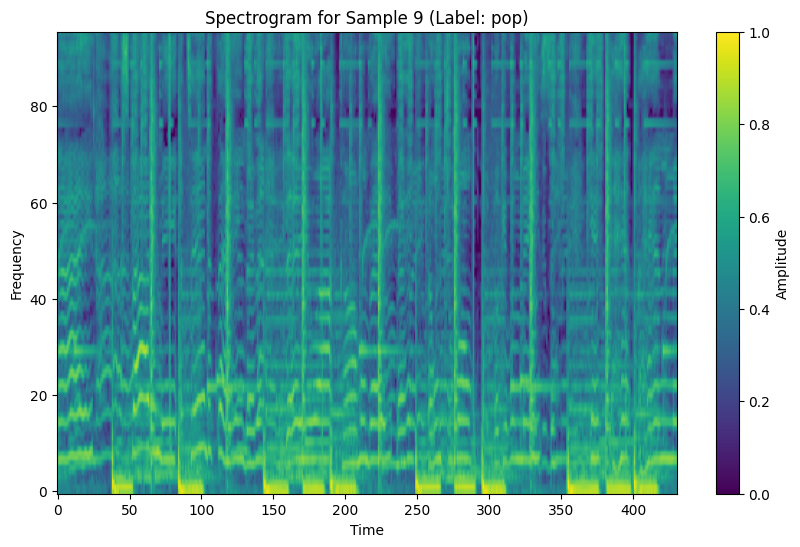

In [95]:
for i in [0, 3, 5, 9]:
    visualize_spectrogram(train_loader_64, sample_index=i)

## ConvRBM

### ConvRBM model

In [96]:
class ConvRBM(nn.Module):
    def __init__(self, visible_channels, hidden_channels, kernel_size=KERNEL_SIZE, learning_rate=1e-3, cd_k=1, batch_size=BATCH_SIZE):
        super(ConvRBM, self).__init__()
        self.visible_channels = visible_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.cd_k = cd_k
        self.batch_size = batch_size

        # Weights & biases
        self.W = nn.Parameter(torch.randn(hidden_channels, visible_channels, kernel_size[0], kernel_size[1]) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(1))
        self.h_bias = nn.Parameter(torch.zeros(hidden_channels, 1, 1))  # per hidden channel bias

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def sample_h(self, v):
        # Convolution to compute hidden probabilities
        # v: [batch, visible_channels, height, width]
        conv_v = nn.functional.conv2d(v, self.W, bias=None)
        h_lin = conv_v + self.h_bias
        h_prob = torch.sigmoid(h_lin)
        h_sample = torch.bernoulli(h_prob)
        return h_prob, h_sample

    def sample_v(self, h):
        # Transposing convolution to reconstruct visible
        # h: [batch, hidden_channels, h_out, w_out]
        deconv_h = nn.functional.conv_transpose2d(h, self.W, bias=None)
        v_lin = deconv_h + self.v_bias
        v_prob = torch.sigmoid(v_lin)
        v_sample = torch.bernoulli(v_prob)
        return v_prob, v_sample

    def forward(self, v):
        # do a forward pass to get hidden probabilities
        h_prob, _ = self.sample_h(v)
        return h_prob

    # Contrastive Divergence - simplified version
    def contrastive_divergence(self, v):
        # Positive phase
        h_prob, h_sample = self.sample_h(v)

        # Negative phase
        v_neg = v
        for _ in range(self.cd_k):
            v_prob_neg, v_sample_neg = self.sample_v(h_sample)
            h_prob_neg, h_sample_neg = self.sample_h(v_sample_neg)
            v_neg = v_sample_neg
            h_sample = h_sample_neg

        # Reconstruction loss
        recon_error = torch.mean((v - v_prob_neg) ** 2)

        if self.training:
            self.optimizer.zero_grad()
            recon_error.backward()
            self.optimizer.step()

        return recon_error.item()

    def transform(self, v, approach="flatten"):
        """
        Transforms the input tensor `v` by applying the ConvRBM transformation and global average pooling
        to output a feature vector of shape [batch_size, n_mels].
        """
        with torch.no_grad():
            h_prob, _ = self.sample_h(v)

            if approach == "global_average_pooling":
                pooled_h_prob = torch.mean(h_prob, dim=3)
                pooled_h_prob = torch.mean(pooled_h_prob, dim=2)


            elif approach == "max_pooling":
                pooled_h_prob = nn.functional.max_pool2d(h_prob, kernel_size=(2, 2), stride=(2, 2))
                

            elif approach == "global_max_pooling":
                pooled_h_prob = torch.max(h_prob, dim=3).values
                pooled_h_prob = torch.max(pooled_h_prob, dim=2).values

            elif approach == "avg_pool2d":
                pooled_h_prob = nn.functional.avg_pool2d(h_prob, kernel_size=(2, 2), stride=(2, 2))

            else:
                pooled_h_prob = h_prob.view(v.size(0), -1)


            return pooled_h_prob.view(v.size(0), -1)

    def train_rbm(self, train_loader, val_loader, epochs=10, device='cpu', save_interval=50, save_dir='./model_weights'):
        """Train the RBM on input data using the provided dataloaders for training and testing."""

        train_losses = []
        val_losses = []

        train_size = len(train_loader.dataset)
        val_size = len(val_loader.dataset)

        print(f"Training set size: {train_size}, Validation set size: {val_size}")

        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        for epoch in range(epochs):

            #TRAINING
            self.train()
            train_loss = 0.0
            with tqdm(train_loader, unit=" batches") as pbar:
                for batch_X, _ in pbar:
                    batch_X = batch_X.to(device)

                    loss = self.contrastive_divergence(batch_X)
                    train_loss += loss

            # Average training loss across all batches
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # VALIDATION
            self.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_X, _ in val_loader:
                    batch_X = batch_X.to(device)

                    loss = self.contrastive_divergence(batch_X)
                    val_loss += loss

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Logging epoch summary
            print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            # Save model weights at intervals
            if (epoch + 1) % save_interval == 0:
                save_path = os.path.join(save_dir, f'rbm_epoch_{epoch + 1}.pth')
                torch.save(self.state_dict(), save_path)
                print(f"Model weights saved to {save_path}")

                # Plot training and validation loss
                plt.figure(figsize=(10, 6))
                plt.plot(range(epoch + 1), train_losses, label='Training Loss')
                plt.plot(range(epoch + 1), val_losses, label='Validation Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss Over Epochs')
                plt.legend()
                plt.grid(True)
                plt.show()
                # saving the plot
                plt.savefig(f'{save_dir}/loss_plot_{epoch + 1}.png')
                


### Instantiating ConvRBM

In [97]:
conv_rbm_64 = ConvRBM(
    visible_channels=VISIBLE_CHANNELS,
    hidden_channels=HIDDEN_CHANNELS,
    kernel_size=KERNEL_SIZE,
    learning_rate=LEARNING_RATE,
    cd_k=CD_K,
    batch_size=BATCH_SIZE
).to(DEVICE)

### Training ConvRBM

Training set size: 799, Validation set size: 100


100%|██████████| 13/13 [00:13<00:00,  1.03s/ batches]


Epoch [1/20] - Train Loss: 0.0398, Val Loss: 0.0338


100%|██████████| 13/13 [00:02<00:00,  4.45 batches/s]


Epoch [2/20] - Train Loss: 0.0323, Val Loss: 0.0294
Model weights saved to ./model_weights/rbm_epoch_2.pth


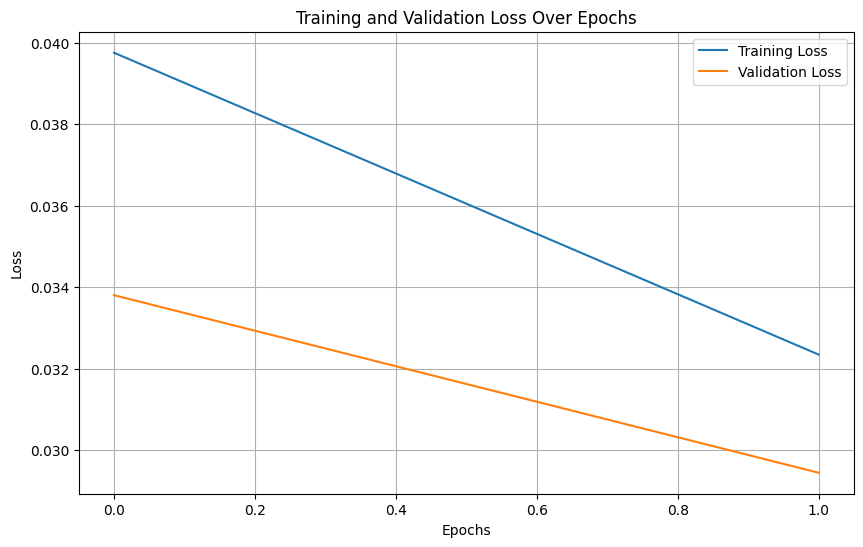

100%|██████████| 13/13 [00:02<00:00,  4.53 batches/s]


Epoch [3/20] - Train Loss: 0.0302, Val Loss: 0.0284


100%|██████████| 13/13 [00:03<00:00,  4.29 batches/s]


Epoch [4/20] - Train Loss: 0.0296, Val Loss: 0.0279
Model weights saved to ./model_weights/rbm_epoch_4.pth


<Figure size 640x480 with 0 Axes>

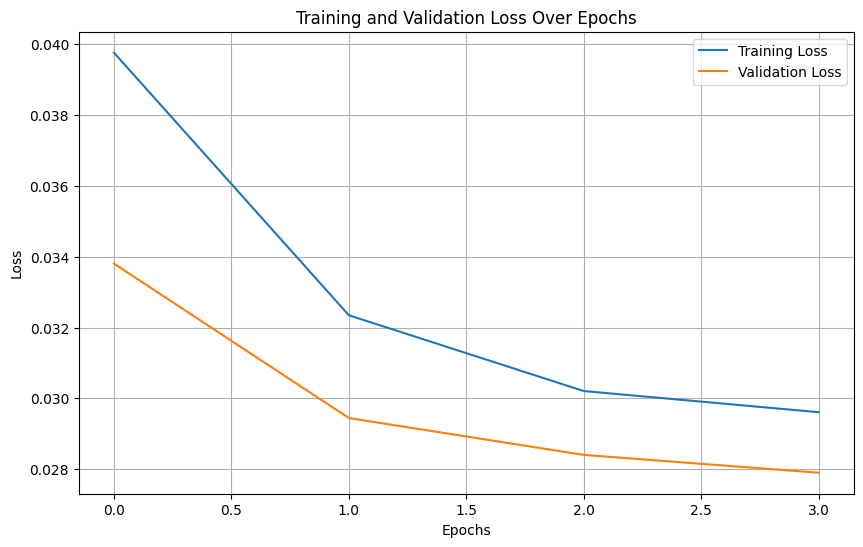

100%|██████████| 13/13 [00:02<00:00,  4.80 batches/s]


Epoch [5/20] - Train Loss: 0.0290, Val Loss: 0.0271


100%|██████████| 13/13 [00:02<00:00,  4.61 batches/s]


Epoch [6/20] - Train Loss: 0.0280, Val Loss: 0.0260
Model weights saved to ./model_weights/rbm_epoch_6.pth


<Figure size 640x480 with 0 Axes>

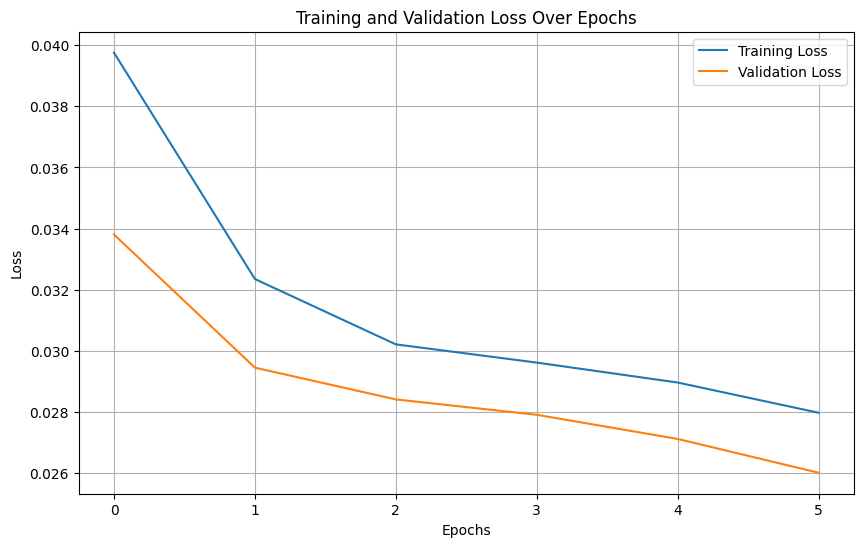

100%|██████████| 13/13 [00:02<00:00,  4.38 batches/s]


Epoch [7/20] - Train Loss: 0.0266, Val Loss: 0.0244


100%|██████████| 13/13 [00:02<00:00,  4.80 batches/s]


Epoch [8/20] - Train Loss: 0.0246, Val Loss: 0.0223
Model weights saved to ./model_weights/rbm_epoch_8.pth


<Figure size 640x480 with 0 Axes>

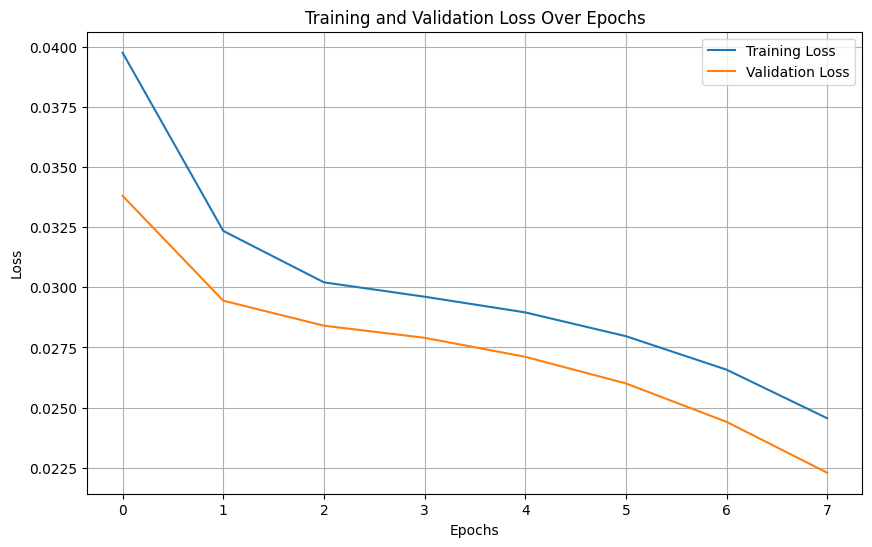

100%|██████████| 13/13 [00:02<00:00,  4.79 batches/s]


Epoch [9/20] - Train Loss: 0.0219, Val Loss: 0.0196


100%|██████████| 13/13 [00:02<00:00,  4.66 batches/s]


Epoch [10/20] - Train Loss: 0.0190, Val Loss: 0.0171
Model weights saved to ./model_weights/rbm_epoch_10.pth


<Figure size 640x480 with 0 Axes>

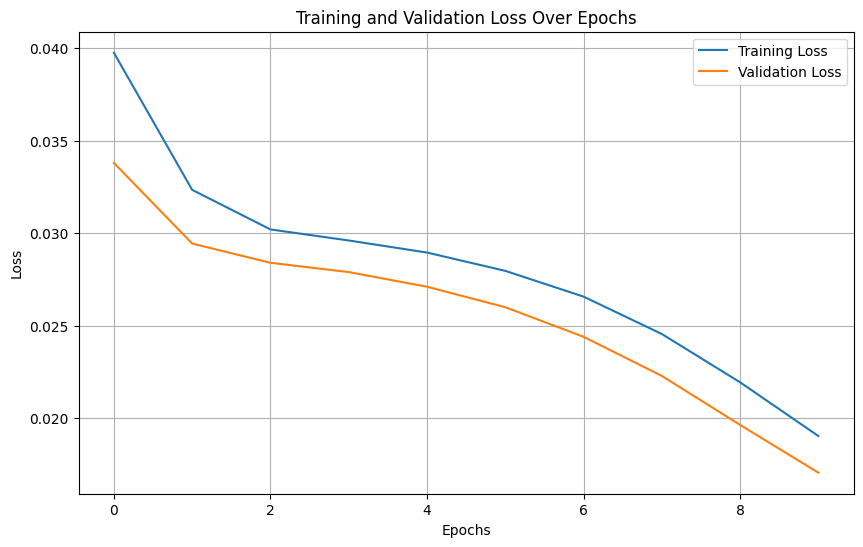

100%|██████████| 13/13 [00:02<00:00,  4.74 batches/s]


Epoch [11/20] - Train Loss: 0.0164, Val Loss: 0.0150


100%|██████████| 13/13 [00:02<00:00,  4.79 batches/s]


Epoch [12/20] - Train Loss: 0.0146, Val Loss: 0.0138
Model weights saved to ./model_weights/rbm_epoch_12.pth


<Figure size 640x480 with 0 Axes>

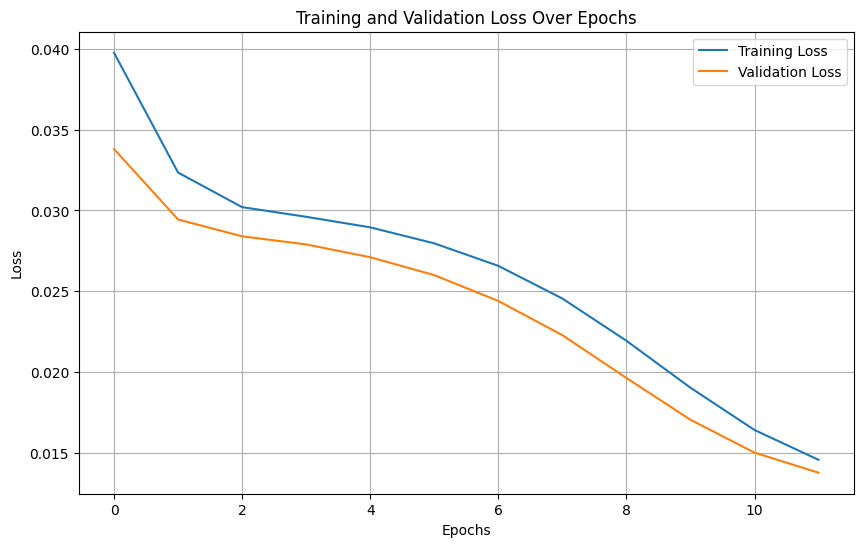

100%|██████████| 13/13 [00:02<00:00,  4.67 batches/s]


Epoch [13/20] - Train Loss: 0.0135, Val Loss: 0.0132


100%|██████████| 13/13 [00:02<00:00,  4.52 batches/s]


Epoch [14/20] - Train Loss: 0.0131, Val Loss: 0.0130
Model weights saved to ./model_weights/rbm_epoch_14.pth


<Figure size 640x480 with 0 Axes>

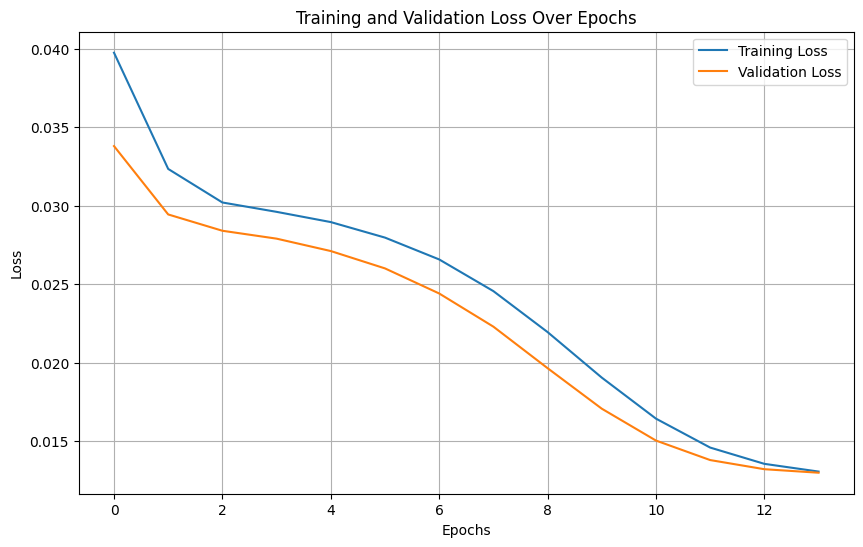

100%|██████████| 13/13 [00:02<00:00,  4.76 batches/s]


Epoch [15/20] - Train Loss: 0.0128, Val Loss: 0.0128


100%|██████████| 13/13 [00:02<00:00,  4.75 batches/s]


Epoch [16/20] - Train Loss: 0.0127, Val Loss: 0.0127
Model weights saved to ./model_weights/rbm_epoch_16.pth


<Figure size 640x480 with 0 Axes>

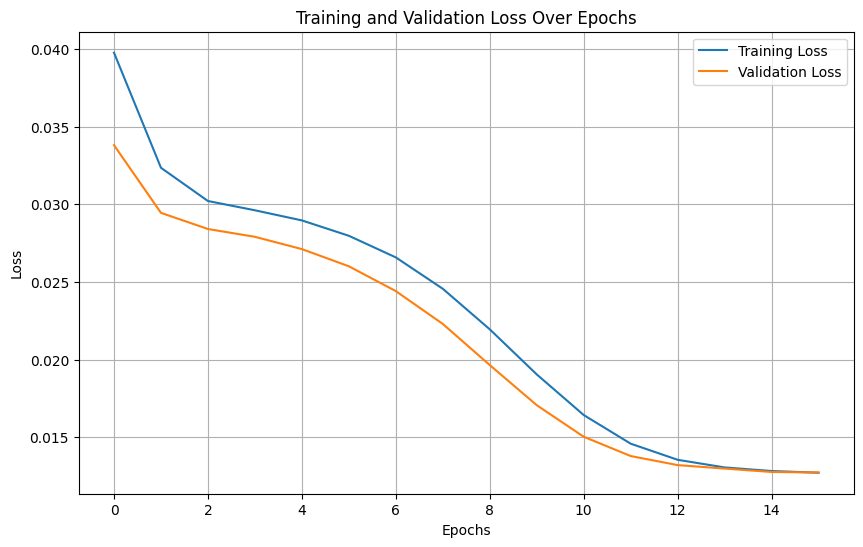

100%|██████████| 13/13 [00:02<00:00,  4.65 batches/s]


Epoch [17/20] - Train Loss: 0.0127, Val Loss: 0.0127


100%|██████████| 13/13 [00:02<00:00,  4.81 batches/s]


Epoch [18/20] - Train Loss: 0.0126, Val Loss: 0.0127
Model weights saved to ./model_weights/rbm_epoch_18.pth


<Figure size 640x480 with 0 Axes>

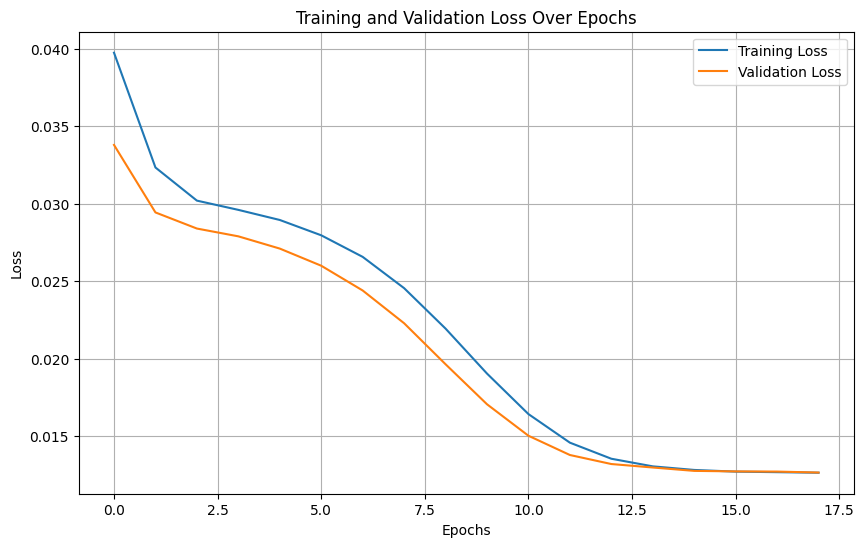

100%|██████████| 13/13 [00:02<00:00,  4.55 batches/s]


Epoch [19/20] - Train Loss: 0.0126, Val Loss: 0.0127


100%|██████████| 13/13 [00:02<00:00,  4.85 batches/s]


Epoch [20/20] - Train Loss: 0.0126, Val Loss: 0.0126
Model weights saved to ./model_weights/rbm_epoch_20.pth


<Figure size 640x480 with 0 Axes>

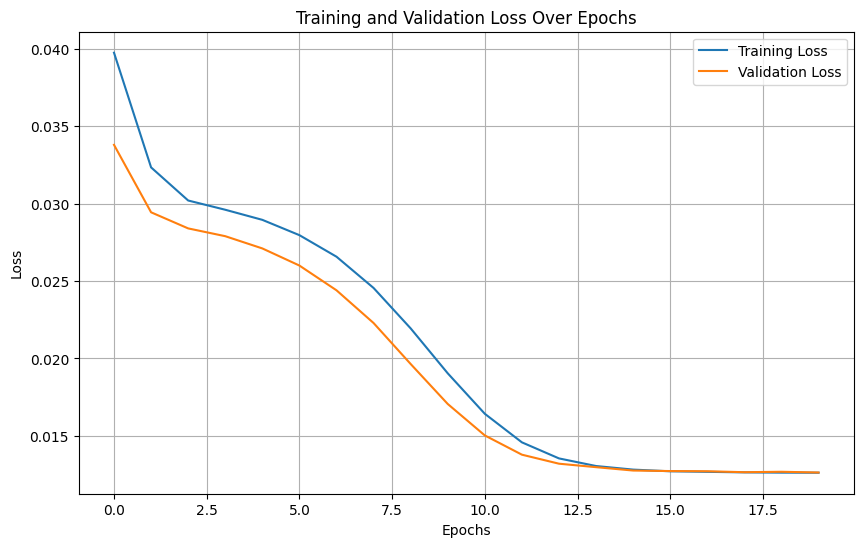

<Figure size 640x480 with 0 Axes>

In [98]:
conv_rbm_64.train_rbm(
    train_loader_64, 
    val_loader_64,
    epochs=20, 
    device=DEVICE,
    save_interval=2)

### Feature Extraction using ConvRBM

In [107]:
# Load the saved model weights for epoch 8 based on the training logs
conv_rbm_64.load_state_dict(torch.load('./model_weights/rbm_epoch_12.pth'))
conv_rbm_64.eval()

train_features = {}
test_features = {}

approaches = ["flatten", "global_average_pooling", "max_pooling", "global_max_pooling", "avg_pool2d"]

for approach in approaches:
    print(f"Processing features for approach: {approach}")
    train_batch = []
    test_batch = []

    with torch.no_grad():
        # Process training features
        for train_X, _ in train_loader_64:
            train_X = train_X.to(DEVICE)
            f = conv_rbm_64.transform(train_X, approach=approach)
            train_batch.append(f.cpu().numpy())

        train_features[approach] = np.concatenate(train_batch, axis=0)

        # Process testing features
        for test_X, _ in test_loader_64:
            test_X = test_X.to(DEVICE)
            f = conv_rbm_64.transform(test_X, approach=approach)
            test_batch.append(f.cpu().numpy())

        # Store all testing features as a single big list in the dictionary
        test_features[approach] = np.concatenate(test_batch, axis=0)

/var/folders/k7/fy1xk_bx2k954dxyll0sm2_40000gp/T/ipykernel_65365/2897072167.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  conv_rbm_64.load_state_dict(torch.load('./mod

Processing features for approach: flatten
Processing features for approach: global_average_pooling
Processing features for approach: max_pooling
Processing features for approach: global_max_pooling
Processing features for approach: avg_pool2d


### Classification

In [108]:
# Extract labels for the train and test datasets
train_labels = []
test_labels = []

for _, label in train_loader_64.dataset:
    train_labels.append(label)

for _, label in test_loader_64.dataset:
    test_labels.append(label)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [110]:
# random forest classifier
for approach in train_features.keys():
    dt_clf = RandomForestClassifier(max_depth=15, random_state=13)
    dt_clf.fit(train_features[approach], train_labels)

    test_predictions = dt_clf.predict(test_features[approach])

    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Decision Tree Classifier Accuracy using {approach} pooling: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions))

Decision Tree Classifier Accuracy using flatten pooling: 0.5200

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.44      0.80      0.57         5
           2       0.71      0.45      0.56        11
           3       0.33      0.50      0.40         6
           4       0.56      0.45      0.50        11
           5       0.64      0.50      0.56        14
           6       0.87      0.76      0.81        17
           7       0.33      0.67      0.44         6
           8       0.33      0.33      0.33        12
           9       0.29      0.20      0.24        10

    accuracy                           0.52       100
   macro avg       0.51      0.53      0.50       100
weighted avg       0.55      0.52      0.52       100

Decision Tree Classifier Accuracy using global_average_pooling pooling: 0.2100

Classification Report:
              precision    recall  f1-score   supp

t-SNE visualization

In [111]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=13)
    tsne_features = tsne.fit_transform(features)

    tsne_df = pd.DataFrame(tsne_features, columns=['Component 1', 'Component 2'])
    tsne_df['Label'] = labels

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=tsne_df, x='Component 1', y='Component 2', hue='Label', palette='tab10', alpha=0.6)
    plt.title('t-SNE Visualization of Audio Features')
    plt.show()


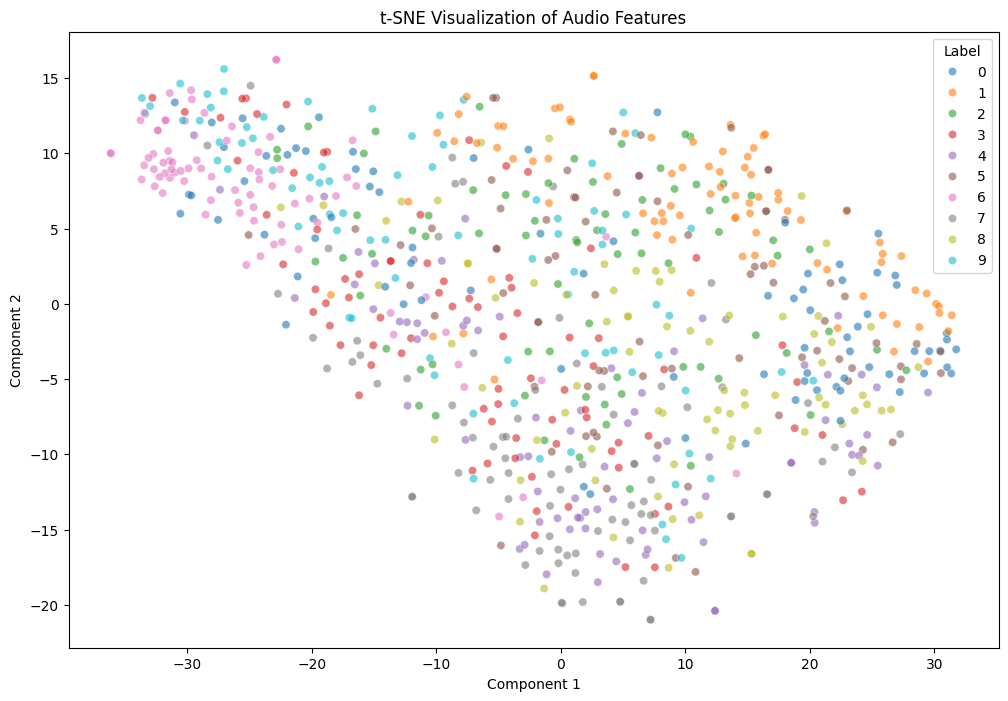

In [113]:
plot_tsne(train_features["avg_pool2d"], train_labels)